<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


## Desafío 3 - Procesamiento del Lenguaje Natural I
##### Docentes: Rodrigo Cárdenas / Nicolás  Vattuone
##### Autora: María Luz Micozzi

## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from tensorflow import keras
from tensorflow.keras.utils import pad_sequences
from keras.layers import Dropout

import re
import os
import gzip
import shutil
import requests

## Preparación de los datos
El corpus seleccionado es una colección de subtítulos de películas y series traducidos al español obtenidos de la web [OPUS](https://opus.nlpl.eu/OpenSubtitles/en&es/v2024/OpenSubtitles). Los mismos fueron recolectados desde el sitio [opensubtitles](https://www.opensubtitles.org/).

Se utilizará la versión más liviana para optimizar el tiempo y la memoria.

In [ ]:
# Obtenemos el archivo txt con los subtitulos

url = "https://object.pouta.csc.fi/OPUS-OpenSubtitles/v1/mono/es.txt.gz"
gz_path = "sub-es.txt.gz"
txt_path = "sub-es.txt"

# Descargar
if not os.path.exists(gz_path):
    print("Descargando archivo .gz...")
    response = requests.get(url)
    response.raise_for_status()
    with open(gz_path, "wb") as f:
        f.write(response.content)
    print("Descarga completada.")
else:
    print("El archivo .gz ya existe.")

# Descomprimir
if not os.path.exists(txt_path):
    print("Descomprimiendo archivo .gz...")
    with gzip.open(gz_path, 'rt', encoding='utf-8') as f_in:
        with open(txt_path, 'w', encoding='utf-8') as f_out:
            f_out.write(f_in.read())
    print("Descompresión completada.")
else:
    print("El archivo .txt ya está descomprimido.")

Descargando archivo .gz...
Descarga completada.
Descomprimiendo archivo .gz...
Descompresión completada.


In [ ]:
# Leemos el archivo y limpiamos el texto

with open("sub-es.txt", "r", encoding="utf-8") as f:
    text = f.read()

def preprocess(text):
    text = text.lower() # Convertir todo el texto a minúsculas
    text = re.sub(r"<.*?>", "", text) # Eliminar etiquetas
    text = re.sub(r"[^a-záéíóúüñ¿¡!?.,;:\-()\"'\s]", "", text) # Eliminar cualquier carácter que no sea letra, puntuación o espacio
    text = re.sub(r"\s+", " ", text).strip() # Reemplazar múltiples espacios/saltos por uno solo y elimina espacios extremos
    return text

clean_text = preprocess(text)

In [ ]:
clean_text[:500]

'sr. bond, sr. bond, qué bueno que lo encontré. llamaron de su oficina. estarán enviando un helicóptero para recogerlo. algún tipo de emergencia. generalmente lo es. gracias. buenas tardes, sr. bond. no se preocupe por el piloto. era uno de los menos útiles. está ahora volando por aerolíneas por control remoto. piénselo bien, . es una larga caída. estuve esperando este momento, sr. bond. y espero disfrutarlo al máximo. en serio, no tiene respeto por los muertos? adiós, sr. bond. espero que haya t'

In [ ]:
print(f'Tamaño: {len(clean_text)}.')

Tamaño: 65855203.


El corpus original luego de la limpieza cuenta con más de 65 millones de caracteres, lo cual resultaba excesivo para entrenar y probar modelos en entornos con recursos limitados.  
Por eso, se redujo el corpus para facilitar el preprocesamiento, reducir el uso de memoria y agilizar la experimentación.


In [ ]:
max_chars = 400_000
clean_text = clean_text[:max_chars]

### Elegir el tamaño del contexto

In [ ]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [ ]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(clean_text)

In [ ]:
# longitud de vocabulario de caracteres
print(f'El vocabulario tiene {len(chars_vocab)} caracteres.')

El vocabulario tiene 47 caracteres.


In [ ]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [ ]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in clean_text]

In [ ]:
tokenized_text[:20]

[30, 22, 7, 36, 11, 23, 35, 24, 9, 36, 30, 22, 7, 36, 11, 23, 35, 24, 9, 36]

### Organizando y estructurando el dataset

In [ ]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [ ]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [ ]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [ ]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [ ]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [ ]:
X.shape

(359900, 100)

In [ ]:
X[0,:10]

array([30, 22,  7, 36, 11, 23, 35, 24,  9, 36])

In [ ]:
y[0,:10]

array([22,  7, 36, 11, 23, 35, 24,  9, 36, 30])

In [ ]:
vocab_size = len(chars_vocab)

## Entrenamiento

In [ ]:
# Configuramos para usar GPU

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, Dense, SimpleRNN, LSTM, GRU
from keras.models import Model, Sequential

Se probarán los 3 modelos propuestos: SimpleRNN, LSTM y GRU.

In [ ]:
# SimpleRNN
model_simpleRNN = Sequential()

model_simpleRNN.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_simpleRNN.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_simpleRNN.add(Dense(vocab_size, activation='softmax'))
model_simpleRNN.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_simpleRNN.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 47)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, None, 200)      │        49,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 47)       │         9,447 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,047 (230.65 KB)

 Trainable params: 59,047 (230.65 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# LSTM
model_LSTM = Sequential()

model_LSTM.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_LSTM.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_LSTM.add(Dense(vocab_size, activation='softmax'))
model_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_LSTM.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ (None, None, 47)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 100)      │        59,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 47)       │         4,747 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,947 (249.79 KB)

 Trainable params: 63,947 (249.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# GRU
model_GRU = Sequential()

model_GRU.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_GRU.add(GRU(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_GRU.add(Dense(vocab_size, activation='softmax'))
model_GRU.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model_GRU.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_2              │ (None, None, 47)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 100)      │        44,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 47)       │         4,747 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,447 (193.15 KB)

 Trainable params: 49,447 (193.15 KB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, model_name, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = history_ppl
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience
      self.model_name = model_name

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(f'{self.model_name}.keras')
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

In [ ]:
epochs = 15

In [ ]:
start_time = time.time()

history_ppl_simpleRNN = []
hist_simpleRNN = model_simpleRNN.fit(X, y, epochs=epochs, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_simpleRNN, model_name='model_simpleRNN')], batch_size=256)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Tiempo de entrenamiento (SimpleRNN): {elapsed_time:.2f} segundos")

Epoch 1/15
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3903
 mean perplexity: 6.319409567507068 

Saved new model!
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 53s 31ms/step - loss: 2.3902
Epoch 2/15
1404/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9437
 mean perplexity: 5.381675513545472 

Saved new model!
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 75s 29ms/step - loss: 1.9436
Epoch 3/15
1404/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8419
 mean perplexity: 5.05717811632396 

Saved new model!
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - loss: 1.8418
Epoch 4/15
1404/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7962
 mean perplexity: 4.778108146322433 

Saved new model!
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - loss: 1.7962
Epoch 5/15
1403/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7692
 mean perplexity: 4.677096918599689 

Saved new model!
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - loss: 1.7692
Epoch 6/15
1405/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.7512
 mean 

In [ ]:
start_time = time.time()

history_ppl_LSTM = []
hist_LSTM = model_LSTM.fit(X, y, epochs=epochs, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_LSTM, model_name='model_LSTM')], batch_size=256)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Tiempo de entrenamiento (LSTM): {elapsed_time:.2f} segundos")

Epoch 1/15
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 2.6777
 mean perplexity: 8.479349522135365 

Saved new model!
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 598s 418ms/step - loss: 2.6775
Epoch 2/15
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 2.1436
 mean perplexity: 7.599021539616225 

Saved new model!
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 560s 376ms/step - loss: 2.1436
Epoch 3/15
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - loss: 2.0554
 mean perplexity: 7.064778404020185 

Saved new model!
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 560s 375ms/step - loss: 2.0554
Epoch 4/15
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 1.9983
 mean perplexity: 6.7373329257246235 

Saved new model!
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 559s 373ms/step - loss: 1.9983
Epoch 5/15
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 1.9500
 mean perplexity: 6.376341280625693 

Saved new model!
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 622s 416ms/step - loss: 1.9500
Epoch 6/15
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - l

In [ ]:
start_time = time.time()

history_ppl_GRU = []
hist_GRU = model_GRU.fit(X, y, epochs=epochs, callbacks=[PplCallback(tokenized_sentences_val,history_ppl_GRU, model_name='model_GRU')], batch_size=256)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Tiempo de entrenamiento (GRU): {elapsed_time:.2f} segundos")

Epoch 1/15
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 2.5088
 mean perplexity: 6.954186821702737 

Saved new model!
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 524s 368ms/step - loss: 2.5086
Epoch 2/15
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 1.9538
 mean perplexity: 5.831301128444959 

Saved new model!
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 607s 400ms/step - loss: 1.9538
Epoch 3/15
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 1.8304
 mean perplexity: 5.36371076047121 

Saved new model!
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 583s 372ms/step - loss: 1.8304
Epoch 4/15
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 1.7674
 mean perplexity: 5.126094857052942 

Saved new model!
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 571s 406ms/step - loss: 1.7674
Epoch 5/15
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 1.7277
 mean perplexity: 4.972419513529869 

Saved new model!
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 575s 373ms/step - loss: 1.7277
Epoch 6/15
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - los

In [ ]:
def plot_ppl(history_ppl, model_name) :
  epoch_count = range(1, len(history_ppl) + 1)

  plt.figure(figsize=(8, 5))
  sns.lineplot(x=epoch_count, y=history_ppl, marker='o')

  plt.title(f"Perplejidad VS Época - {model_name}")
  plt.xlabel("Épocas")
  plt.ylabel("Perplejidad")
  plt.xticks(epoch_count)

  plt.grid(True)
  plt.tight_layout()
  plt.show()

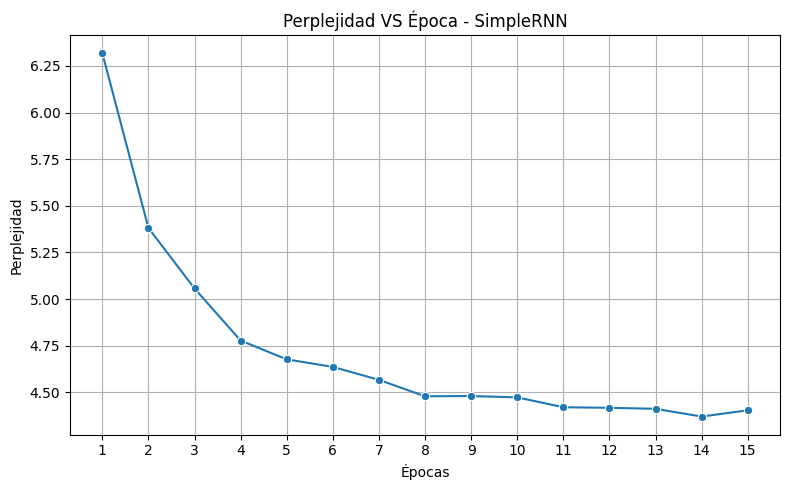

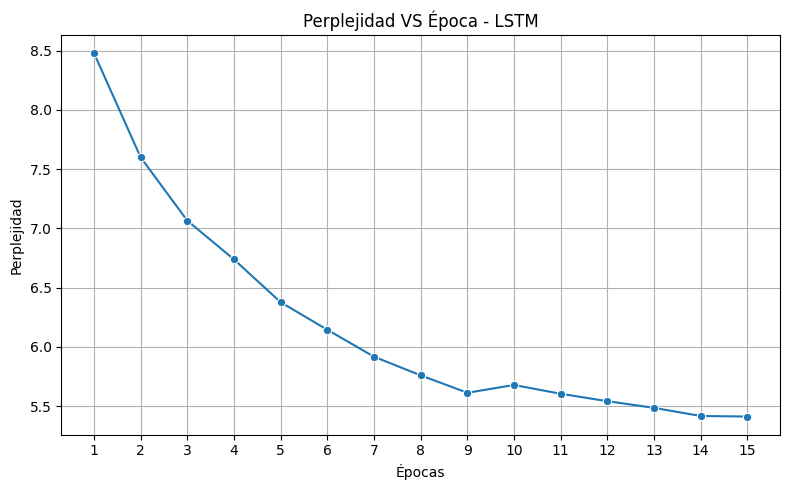

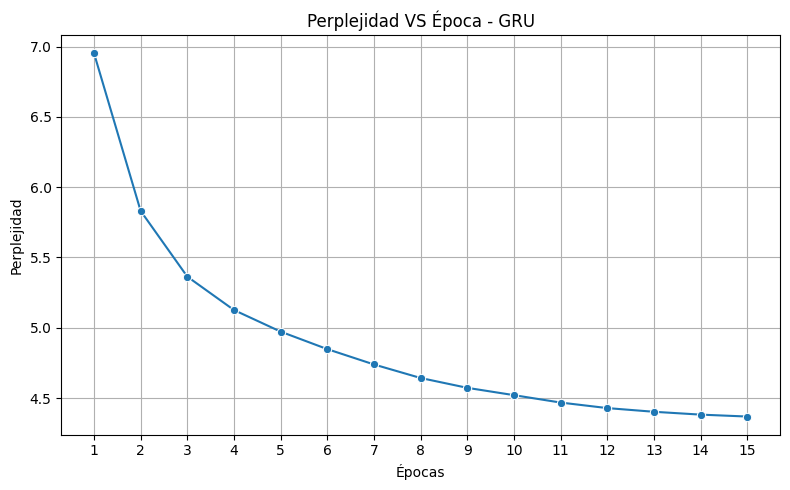

In [ ]:
# Gráficamos Perplejidad VS Época para cada uno de los 3 modelos
plot_ppl(history_ppl_simpleRNN, "SimpleRNN")
plot_ppl(history_ppl_LSTM, "LSTM")
plot_ppl(history_ppl_GRU, "GRU")

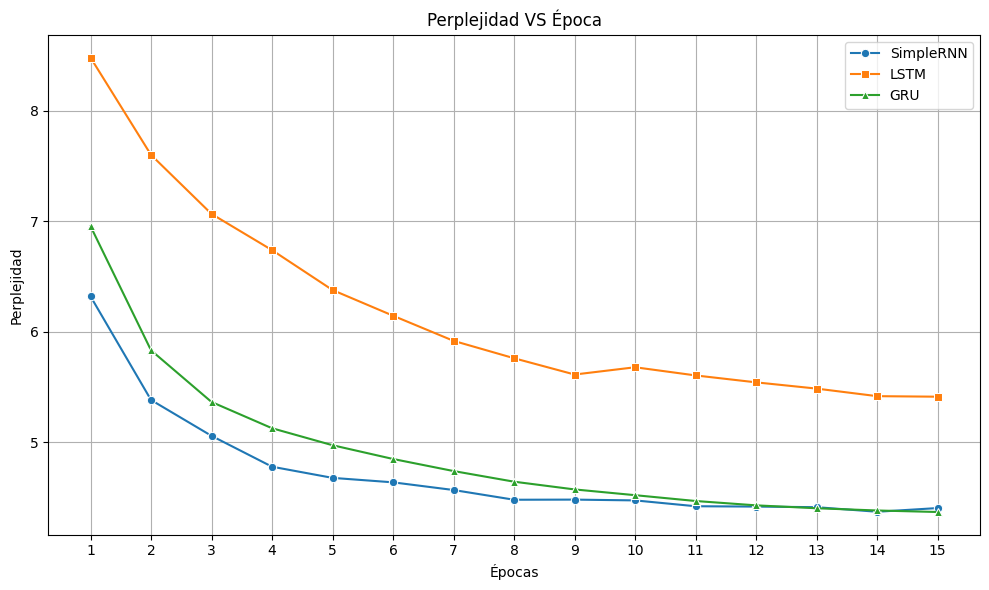

In [ ]:
# Gráfico comparativo de Perplejidad VS Época para los 3 modelos

epochs = list(range(1, len(history_ppl_simpleRNN) + 1))
plt.figure(figsize=(10, 6))

sns.lineplot(x=epochs, y=history_ppl_simpleRNN, label='SimpleRNN', marker='o')
sns.lineplot(x=epochs, y=history_ppl_LSTM, label='LSTM', marker='s')
sns.lineplot(x=epochs, y=history_ppl_GRU, label='GRU', marker='^')

plt.title('Perplejidad VS Época')
plt.xlabel('Épocas')
plt.ylabel('Perplejidad')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Comparación de los modelos

### Resultados finales tras 15 épocas

| Modelo     | Perplejidad Final | Tiempo de Entrenamiento |
|------------|-------------------|--------------------------|
| SimpleRNN  | 4.40              | 609 s (≈ 10 min)         |
| LSTM       | 5.41              | 8662 s (≈ 144 min)       |
| GRU        | 4.37              | 8653 s (≈ 144 min)       |

### Observaciones

- **GRU** obtuvo la menor perplejidad (≈ 4.37), ligeramente mejor que SimpleRNN.
- **SimpleRNN** entrenó muchísimo más rápido (≈ 10 minutos), con un desempeño competitivo.
- **LSTM** tuvo la mayor perplejidad final, pese a su alto costo computacional.

Para los 3 modelos vemos en los gráficos que con más épocas de entrenamiento podríamos seguir disminuyendo la perplejidad.

En este caso, GRU ofrece el mejor equilibrio entre capacidad y generalización, aunque SimpleRNN puede ser una buena opción para prototipos rápidos.
Teniendo en cuanta que el resultado es apenas inferior al de GRU, pero se entrenó mucho más rápido, SimpleRNN puede ser la mejor opción

## Prueba de los modelos entrenados

In [ ]:
# Cargamos los mejores modelos guardados
model_simpleRNN = keras.models.load_model('model_simpleRNN.keras')
model_LSTM = keras.models.load_model('model_LSTM.keras')
model_GRU = keras.models.load_model('model_GRU.keras')

### Predicción del próximo caracter

In [ ]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [ ]:
import gradio as gr

def model_response(human_text, model=model_simpleRNN):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

In [ ]:
iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://86d4245fb2cc11708f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://86d4245fb2cc11708f.gradio.live


In [ ]:
text = "Person"
print(f'Respuesta SimpleRNN: {model_response(text, model_simpleRNN)}')
print(f'Respuesta LSTM: { model_response(text, model_LSTM) }')
print(f'Respuesta GRU: {model_response(text, model_GRU)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Respuesta SimpleRNN: Persona
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Respuesta LSTM: Person 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Respuesta GRU: Persona


### Greedy search

In [ ]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [ ]:
input_text='habia una vez'

print(generate_seq(model_simpleRNN, input_text, max_length=max_context_size, n_words=30))
print(generate_seq(model_LSTM, input_text, max_length=max_context_size, n_words=30))
print(generate_seq(model_GRU, input_text, max_length=max_context_size, n_words=30))

habia una vez que está bien? - ¿qué está bi
habia una vez? - ¿qué está bien? - ¿qué est
habia una vez de la contrar a la contrar a 


In [ ]:
input_text='hoy es un día para'

print(generate_seq(model_simpleRNN, input_text, max_length=max_context_size, n_words=30))
print(generate_seq(model_LSTM, input_text, max_length=max_context_size, n_words=30))
print(generate_seq(model_GRU, input_text, max_length=max_context_size, n_words=30))

hoy es un día para la contar es muy bien? - ¿qué
hoy es un día para que está bien? - ¿qué está bi
hoy es un día para con el contrar esta muerte. -


In [ ]:
input_text='Sr. Bond, usted es'

print(generate_seq(model_simpleRNN, input_text, max_length=max_context_size, n_words=30))
print(generate_seq(model_LSTM, input_text, max_length=max_context_size, n_words=30))
print(generate_seq(model_GRU, input_text, max_length=max_context_size, n_words=30))

Sr. Bond, usted es mi como si es serio. - ¿qué e
Sr. Bond, usted está bien. - ¿qué está bien? - ¿
Sr. Bond, usted es un poco de la contrar a la co


###  Beam search

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [ ]:
def generate_text(input_text, mode, temp=1):
    modelos = {
        "SimpleRNN": model_simpleRNN,
        "LSTM": model_LSTM,
        "GRU": model_GRU
    }

    for nombre, modelo in modelos.items():
        print(f"\n--- Modelo: {nombre} | Modo: {mode} | Temperatura: {temp} ---")
        salidas = beam_search(
            modelo,
            num_beams=10,
            num_words=30,
            input=input_text,
            temp=temp,
            mode=mode
        )
        print(decode(salidas[0]))


In [ ]:
input = 'habia una vez'
generate_text(input_text=input, mode='det', temp=1)
generate_text(input_text=input, mode='sto', temp=1)
generate_text(input_text=input, mode='sto', temp=2)
generate_text(input_text=input, mode='sto', temp=5)


--- Modelo: SimpleRNN | Modo: det | Temperatura: 1 ---
habia una vez que está bien? - no lo siento

--- Modelo: LSTM | Modo: det | Temperatura: 1 ---
habia una vez? ¿qué está bien? - ¿qué está 

--- Modelo: GRU | Modo: det | Temperatura: 1 ---
habia una vez para que no tengo que no pued

--- Modelo: SimpleRNN | Modo: sto | Temperatura: 1 ---
habia una vez? - no sé que no te estás desp

--- Modelo: LSTM | Modo: sto | Temperatura: 1 ---
habia una vez? - ¿qué estás por qué te que 

--- Modelo: GRU | Modo: sto | Temperatura: 1 ---
habia una vez de la mierda. - ¿qué está cas

--- Modelo: SimpleRNN | Modo: sto | Temperatura: 2 ---
habia una vez los favor! una cinco sobre an

--- Modelo: LSTM | Modo: sto | Temperatura: 2 ---
habia una vez? ¿no te que te decir? emporo 

--- Modelo: GRU | Modo: sto | Temperatura: 2 ---
habia una vez de milando. para que se me ab

--- Modelo: SimpleRNN | Modo: sto | Temperatura: 5 ---
habia una vezval há muerta redilliaima ektt

--- Modelo: LSTM | Modo: sto | T

In [ ]:
input = 'sr. bond, usted es'
generate_text(input_text=input, mode='det', temp=1)
generate_text(input_text=input, mode='sto', temp=1)
generate_text(input_text=input, mode='sto', temp=2)
generate_text(input_text=input, mode='sto', temp=5)


--- Modelo: SimpleRNN | Modo: det | Temperatura: 1 ---
sr. bond, usted está bien. ¿qué está bien? - no 

--- Modelo: LSTM | Modo: det | Temperatura: 1 ---
sr. bond, usted está bien.......................

--- Modelo: GRU | Modo: det | Temperatura: 1 ---
sr. bond, usted está bien. por favor, por favor.

--- Modelo: SimpleRNN | Modo: sto | Temperatura: 1 ---
sr. bond, usted está bien. vamos. - no lo siento

--- Modelo: LSTM | Modo: sto | Temperatura: 1 ---
sr. bond, usted está bien. - ¿por qué no puede e

--- Modelo: GRU | Modo: sto | Temperatura: 1 ---
sr. bond, usted estaba con ellos. está bien. ¿cu

--- Modelo: SimpleRNN | Modo: sto | Temperatura: 2 ---
sr. bond, usted es mí. bien, no me dijeron tengo

--- Modelo: LSTM | Modo: sto | Temperatura: 2 ---
sr. bond, usted estás miner aquí. trato está ent

--- Modelo: GRU | Modo: sto | Temperatura: 2 ---
sr. bond, usted estoy estaba a salva. la pita. ¿

--- Modelo: SimpleRNN | Modo: sto | Temperatura: 5 ---
sr. bond, usted estttibienda."mu

### Conclusión de resultados

Los tres modelos entrenados (SimpleRNN, LSTM y GRU) muestran diferencias claras en su comportamiento tanto en la predicción puntual del próximo carácter como en la generación secuencial de texto.

- Predicción del próximo carácter:  
  SimpleRNN y GRU tienden a completar correctamente palabras, en este caso "Persona", mientras que LSTM no logró completarla reflejando una predicción más conservadora o menos precisa en este caso puntual.

- Generación de secuencias con Greedy Search:  
  Los modelos SimpleRNN y LSTM generan frases algo más coherentes en relación a las palabras que forman, aunque con repeticiones o frases poco naturales. GRU tiende a producir frases menos coherentes o con palabras inusuales, posiblemente por un mayor riesgo de desviarse del contexto en búsqueda codiciosa.

- Generación con Beam Search y diferentes temperaturas:  
  - En modo determinístico (temperatura = 1), los tres modelos producen frases coherentes, con SimpleRNN y LSTM generando textos más estructurados y formales, mientras GRU introduce frases más variadas pero a veces incoherentes.  
  - En modo estocástico y con temperaturas crecientes, los tres modelos comienzan a producir textos menos coherentes y con mayor ruido, especialmente a temperaturas altas (5), donde el texto pierde sentido, lo cual es esperado por la mayor aleatoriedad.

- Balance general:  
  SimpleRNN ofrece resultados buenos en cuanto a coherencia y rapidez, siendo competitivo frente a modelos más complejos. LSTM genera textos más conservadores y menos variados, que podrían ser pulidos con más entrenamiento o ajuste. GRU, aunque tiene la mejor perplejidad final, presenta resultados más variados, lo que indica potencial para creatividad pero también inestabilidad en generación libre.

## Conclusión final

Ninguno de los modelos es del todo bueno para la generación de texto. Aunque se forman palabras correctas, las frases generadas no son muy coherentes sintácticamente ni semánticamente. Esto limita su utilidad para aplicaciones que requieran textos fluidos y naturales.

Como próximos pasos, y disponiendo de más tiempo y recursos, se podría:

- Entrenar con un corpus más amplio y representativo.  
- Aumentar la cantidad de épocas de entrenamiento para mejorar la convergencia.  
- Probar arquitecturas más complejas que puedan capturar mejor las dependencias del lenguaje.  
- Realizar una búsqueda y ajuste más exhaustivo de hiperparámetros para optimizar el desempeño.

Estas acciones pueden ayudar a mejorar la coherencia y calidad de las secuencias generadas.